In [1]:
import monai
import torch
import tempfile
import os
import glob
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
root_dir = tempfile.mkdtemp()
data_dir = os.path.join(root_dir, "synthetic_data")

save_img = monai.transforms.SaveImage(output_dir=data_dir, output_postfix="img", print_log=False)

for i in range(50):
    img, seg = monai.data.synthetic.create_test_image_3d(
        64, 64, 64,
        num_objs=1,
        rad_max=30, rad_min=24,
        noise_max=0.5,
        num_seg_classes=1,
        channel_dim=0,
        random_state=None
    )
    save_img(img)

data = [{'img':img_path} for img_path in glob.glob(os.path.join(data_dir, "*/*img.nii.gz"))]

In [3]:
# this includes cases where img1=img2, but whatever
data_pairs = [{'img1':d1['img'], 'img2':d2['img']} for d1 in data for d2 in data]

In [4]:
transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=['img1', 'img2'], image_only=True),
        monai.transforms.ToTensorD(keys=['img1', 'img2']),
        monai.transforms.AddChannelD(keys=['img1','img2']),
        monai.transforms.ConcatItemsD(keys=['img1', 'img2'], name='img12', dim=0),
        monai.transforms.DeleteItemsD(keys=['img1', 'img2']),
    ]
)

In [5]:
dataset_pairs = monai.data.CacheDataset(
    data=data_pairs,
    transform=transform_pair,
    cache_num=64
)

Loading dataset: 100%|██████████| 64/64 [00:00<00:00, 70.81it/s]


In [6]:
def create_reg_net():
    return monai.networks.nets.UNet(
        3,  # spatial dims
        2,  # input channels (one for fixed image and one for moving image)
        3,  # output channels (to represent 3D displacement vector field)
        (16, 32, 32, 32, 32),  # channel sequence
        (1, 2, 2, 2),  # convolutional strides
        dropout=0.2,
        norm="batch"
    )

warp = monai.networks.blocks.Warp()

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


In [7]:
dataloader = monai.data.DataLoader(
    dataset_pairs,
    batch_size=8,
    num_workers=4,
    shuffle=True
)

In [8]:
def get_grad_size(model):
    total_norm = 0.
    for p in model.parameters():
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

In [9]:
def train(reg_net, max_epochs, batches_per_epoch, learning_rate, lncc_kernel_size):
    
    lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
        spatial_dims=3,
        kernel_size=lncc_kernel_size,
        kernel_type='rectangular',
        reduction="mean"
    )
    
    optimizer = torch.optim.Adam(reg_net.parameters(), learning_rate)
    
    training_losses = []
    grad_sizes = []

    for epoch_number in range(max_epochs):
        print(f"Epoch {epoch_number+1}/{max_epochs}:")
        losses = []
        batch_grad_sizes = []
        for batch_number, batch in enumerate(dataloader):
            if batch_number >= batches_per_epoch: break
            optimizer.zero_grad()

            img12 = batch['img12'].cuda()
            displacement_field12 = reg_net(img12)
            warped_img2 = warp(img12[:, [1], :, :, :], displacement_field12)
            loss = lncc_loss(
                warped_img2,  # prediction
                img12[:, [0], :, :, :]  # target
            )

            loss.backward()
            grad_size = get_grad_size(reg_net)
            batch_grad_sizes.append(grad_size)
            optimizer.step()
            losses.append(loss.item())

        training_loss = np.mean(losses)
        grad_size = np.mean(batch_grad_sizes)
        print(f"\ttraining loss: {training_loss}")
        print(f"\tgrad size: {grad_size}")
        training_losses.append(training_loss)
        grad_sizes.append(grad_size)
        

    plt.plot(training_losses)
    plt.show()

Epoch 1/60:


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


	training loss: -0.32852579777439433
	grad size: 0.10435848846089169
Epoch 2/60:
	training loss: -0.3338219231615464
	grad size: 0.08792682026912572
Epoch 3/60:
	training loss: -0.3439190437396367
	grad size: 0.08168043100363284
Epoch 4/60:
	training loss: -0.35592753005524475
	grad size: 0.08405514084343535
Epoch 5/60:
	training loss: -0.37545093583563965
	grad size: 0.10068616747924819
Epoch 6/60:
	training loss: -0.4082678860674302
	grad size: 0.1426689036875101
Epoch 7/60:
	training loss: -0.4522862955927849
	grad size: 0.18437502612520262
Epoch 8/60:
	training loss: -0.47967232825855416
	grad size: 0.20682679706115537
Epoch 9/60:
	training loss: -0.49806285214920837
	grad size: 0.2067865101259739
Epoch 10/60:
	training loss: -0.5345450472086668
	grad size: 0.21735192725362454
Epoch 11/60:
	training loss: -0.6088057098289331
	grad size: 0.30029744186980395
Epoch 12/60:
	training loss: -0.6917790149648985
	grad size: 0.3156584464147149
Epoch 13/60:
	training loss: -0.774956177920103

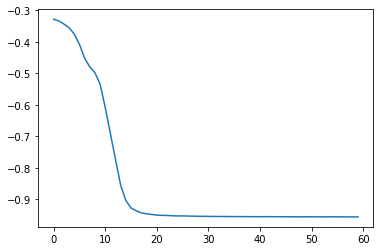

In [10]:
reg_net = create_reg_net().cuda()
train(reg_net, 60, 48, 1e-4, 3)

Epoch 1/60:
	training loss: -0.5087688428660234
	grad size: 676.9981543407238
Epoch 2/60:
	training loss: -0.5084229918817679
	grad size: 1771.5903786392591
Epoch 3/60:
	training loss: -0.5064339948197206
	grad size: 1763.3480309995896
Epoch 4/60:
	training loss: -0.5141817250599464
	grad size: 1047.7820882046087
Epoch 5/60:
	training loss: -0.5173048544675112
	grad size: 1563.3641713653851
Epoch 6/60:
	training loss: -0.5212144932399193
	grad size: 1192.8598168946398
Epoch 7/60:
	training loss: -0.5299426186829805
	grad size: 1706.4055013358018
Epoch 8/60:
	training loss: -0.5255312863737345
	grad size: 5070.453641506907
Epoch 9/60:
	training loss: -0.5251059693594774
	grad size: 3866.428711401217
Epoch 10/60:
	training loss: -0.5176760163158178
	grad size: 3186.938835429386
Epoch 11/60:
	training loss: -0.5018116223315398
	grad size: 10043.173927206712
Epoch 12/60:
	training loss: -0.4942246296753486
	grad size: 6216.180921768471
Epoch 13/60:
	training loss: -0.49117772405346233
	gra

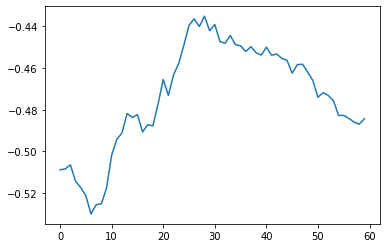

In [11]:
# same as above, but with large lncc kernel_size
reg_net = create_reg_net().cuda()
train(reg_net, 60, 48, 1e-4, 25)